# Diabetes Dataset
This dataset was used in https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf
by Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani, in Annals of Statistics (2004).

As part of the activities in _MCZA015 - 13_ in Universidade Federal do ABC(UFABC) in 2019.

Some general ideas to approach the problem:

   - linear regression
   - 30% teste - NO DATA LEAKAGE PLS
   - START WITH ONE PREDICTOR PER MODEL
   - y relation to prediction is linear? necessary to add polynomial features?
   - try to add more atributes to model
   - use CV to compare different models
   - Try fitting model without and with RIDGE
   - check for corr between atributes to look for colinearity
   - do models suffer degradation for test?
   - is test and train cv ordering of models similar?



A dataset that at first glance is clean and presents no null values.
Atributes such as 'age', 'bmi', 'map' seem adequate.
'Sex' shows by the mean that there are more of sex '1'.

'y' represents how critical is each patient's case. lower: better, higher: worse.



In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

   

def ridge_reg(x,y):
    grau = 8
    poli = PolynomialFeatures(grau, include_bias=False)
    x_poli = poli.fit_transform(x[:, np.newaxis])

    poli_model = Ridge(fit_intercept=True, alpha=4)
    poli_model.fit(x_poli, y)

    # vamos gerar novos pontos x para avaliar o modelo gerado
    xbase = np.linspace(0, 10, 1000)
    # os novos pontos precisam ser aumentados também com os
    # atributos polinomiais
    xfit = poli.fit_transform(xbase[:, np.newaxis])
    yfit = poli_model.predict(xfit)

    print("Coeficientes:      ", poli_model.coef_)
    print("Ordenada na origem:", poli_model.intercept_)
    print("Erro quadrático médio:", mean_squared_error(y, poli_model.predict(x_poli)))
    print("R^2:", r2_score(y, poli_model.predict(x_poli)))
    plt.scatter(x, y)
    plt.plot(xbase, yfit);

In [2]:
df = pd.read_csv("diabetes.csv")
print(df.columns)

df.head()
df.describe()
df.corr()

Index(['age', 'sex', 'bmi', 'map', 'tc ', 'ldl', 'hdl', 'tch', 'ltg', 'glu',
       'y'],
      dtype='object')


,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,-0.011547,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.023551,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.029040,0.388680,0.586450
map,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.014083,0.390430,0.441482
tc,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.101892,0.325717,0.212022
ldl,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.081549,0.290600,0.174054
hdl,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.059842,-0.273697,-0.394789
tch,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.086699,0.417212,0.430453
ltg,-0.011547,0.023551,0.029040,0.014083,0.101892,0.081549,-0.059842,0.086699,1.000000,0.080297,0.102524
glu,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.080297,1.000000,0.382483


_Podemos remover a ldl pois apresenta baixa correlação com y, ao mesmo tempo que apresenta alta colinearidade com tc(0.87) e tch(0.65)_

In [35]:
a = df[df['ltg']<3000]['ltg']
b = df[df['ltg']<3000]['y']
c = df[df['ltg']>3000]['ltg']
d = df[df['ltg']>3000]['y']

print('For ltg < 3000 the corr with y is:',a.corr(b),'\nFor ltg > 3000 the corr with y is: ',c.corr(d))

For ltg < 3000 the corr with y is: 0.5728231096377955 
For ltg > 3000 the corr with y is:  0.47193903679821814


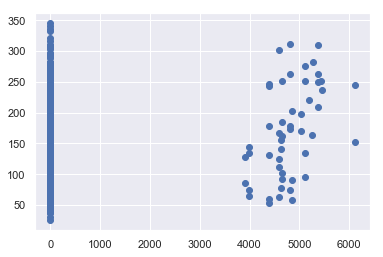

In [38]:
plt.scatter(df['ltg'],df['y'])

_It seems that there is a stronger correlation between lower values of 'ltg' and 'y', however it is not a lot higher than the values above the 3000 bound. While its correlaton as a whole to the outcome is low(0.102), if we split, both ends have considerably stronger correlations to the outcome variable. But I am not sure if this process wouldn't introduce bias in our data._

_In the above plot it is clear that there are high and low values of 'ltg' for any value of 'y'. That must indicate that this does not seem as a good variable to keep._

__How should we treate this variabe? Split it in two columns(value is above 3000? = 1 else =0) or transform it?__
    
_Sex is extremely low correlated to the outcome while is correlated to hdl negatively(-0.379) and tch positively(0.332). So leaving it aside may improve the model._

In [31]:
def poly_reg(DATA,degree,columns):
    X_train,X_test,y_train,y_test = train_test_split(
        DATA[columns],df['y'],test_size=0.3,shuffle=False)

    grau = degree
    poli = PolynomialFeatures(grau, include_bias=False)
    x_poli = poli.fit_transform(X_train)

    poli_model = LinearRegression(fit_intercept=True)
    poli_model.fit(x_poli, y_train)

    xbase = np.linspace(0, 10, 1000)

    eval_score = cross_val_score(poli_model,x_poli,y_train,scoring='r2',cv=10)
    return np.mean(eval_score)

poly_reg(df,1,df.columns.difference(['sex','y']))

0.38137666543628984

col0 = linear
col1 = no change
col2 = linear
col3 = linear
col4 = linear
col5 = linear
col6 = 2 or 6
col7 = linear
col8 = 4
col9 = 2

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DC3362A20>,
      dtype=object)

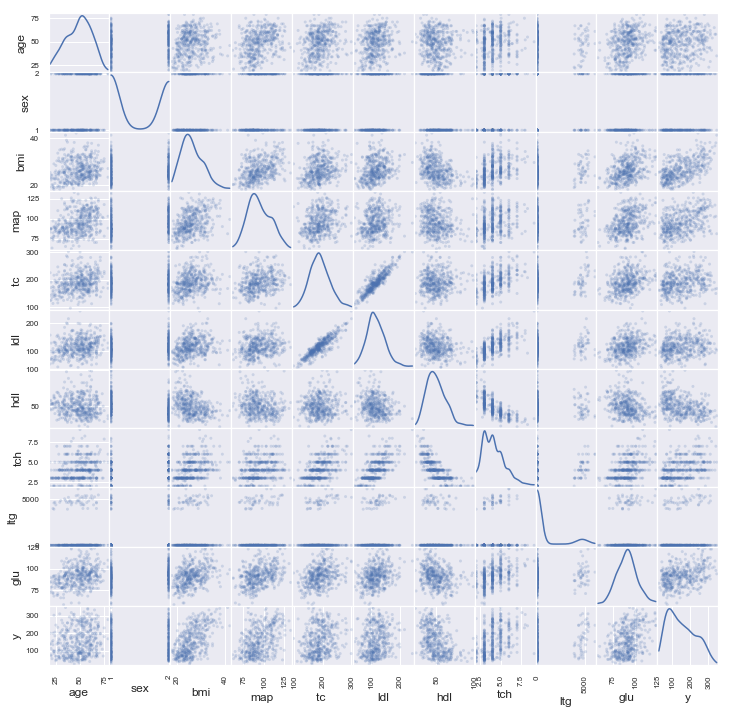

In [12]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha = 0.2, figsize = (12, 12), diagonal = 'kde')

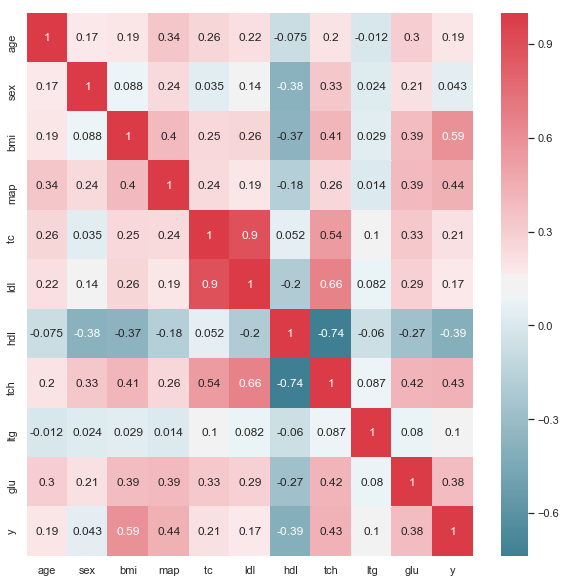

In [13]:
plt.figure(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(),annot=True, fmt='.2g',cmap=cmap)

In [ ]:
   
'''

print("Coeficientes:      ", poli_model.coef_)
print("Ordenada na origem:", poli_model.intercept_)
print("Erro quadrático médio:", mean_squared_error(y, poli_model.predict(x_poli)))
print("R^2:", r2_score(y, poli_model.predict(x_poli)))
plt.scatter(x, y)
plt.plot(xbase, yfit);

residuos = y_train - poli_model.predict(x_poli)
plt.scatter(X_train, residuos);

#dia_reg(data=df,degree=2,columns=0)


------
def cv(model,X,y):
    scores = cross_val_score(model, X, y, scoring="r2", cv=10)

    print("R^2 médio:", scores.mean())
    print("desvio padrão:", scores.std())
    print("R^2 máximo:", scores.max())
    print("R^2 mínimo:", scores.min())'''